Importing required libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_columns', None)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

In [4]:
df = pd.read_excel(r"C:\Users\pc\Documents\JUPYTER ML\End-to-End-ML-Project-\src\notebook\data\US Insurance Claims Data (1).xlsx")
df.head(5)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,154,34,795697,2022-03-30 19:28:31.971,IL,500/1000,998,856.999452,3998347,419228,FEMALE,Associate,priv-house-serv,yachting,husband,800,0,2023-11-26 16:56:09.937,Multi-vehicle Collision,Front Collision,Minor Damage,Other,SC,Columbus,9489 3rd St,9,3,NO,2,1,?,67253,11362,11390,46297,Ford,F150,1997,N
1,172,36,792268,2001-04-27 22:40:12.961,OH,250/500,987,1282.389619,0,420170,MALE,College,machine-op-inspct,basketball,unmarried,51203,0,2018-02-14 10:45:28.353,Single Vehicle Collision,Rear Collision,Total Loss,Fire,SC,Springfield,9818 Cherokee Ave,22,1,YES,2,3,NO,52481,9427,9428,33509,Accura,MDX,1980,N
2,353,47,568504,2011-12-25 09:00:46.445,IN,250/500,1976,1145.490048,0,421251,MALE,High School,prof-specialty,camping,husband,0,0,2021-01-25 02:32:56.598,Single Vehicle Collision,Side Collision,Minor Damage,Other,SC,Columbus,2862 Tree Ridge,5,1,YES,0,3,?,62665,5441,11077,44771,Dodge,RAM,2010,N
3,47,37,971810,2021-12-17 10:10:11.341,IN,250/500,1999,1255.267879,0,421620,MALE,High School,other-service,movies,not-in-family,74892,0,2023-10-29 03:24:47.309,Parked Car,?,Minor Damage,NaN,NY,Hillsdale,8749 Tree St,18,1,NO,1,0,NO,6614,670,667,5423,Jeep,Wrangler,1983,N
4,301,50,898345,2001-01-25 21:42:10.693,IL,100/300,1995,1376.096761,0,421961,FEMALE,High School,farming-fishing,bungie-jumping,own-child,0,-42222,2018-01-20 00:28:30.891,Multi-vehicle Collision,Front Collision,Total Loss,Fire,NY,Hillsdale,5924 Maple Drive,21,3,YES,0,2,?,66431,12218,6086,48589,Volkswagen,Jetta,2036,N


In [ ]:
df_num = df._get_numeric_data()
df_num.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year'],
      dtype='object')

Data Cleaning

In [178]:
df.replace('?', np.nan, inplace=True)

df_missing_target = df[df['fraud_reported'].isna()]

df = df.dropna(subset=['fraud_reported'])

df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['bind_year'] = df['policy_bind_date'].dt.year
df['bind_month'] = df['policy_bind_date'].dt.month
#df['bind_month_name'] = df['policy_bind_date'].dt.month_name()
df['bind_dayofweek'] = df['policy_bind_date'].dt.dayofweek
#df['bind_day_name'] = df['policy_bind_date'].dt.day_name()
df['bind_day'] = df['policy_bind_date'].dt.day
df['bind_hour'] = df['policy_bind_date'].dt.hour

df.drop(['policy_bind_date', 'incident_date'], axis=1, inplace=True)

df['make_model'] = df['auto_make'].astype(str) + '_' + df['auto_model'].astype(str)
df.drop(['auto_make', 'auto_model'], axis=1, inplace=True)

In [179]:
df.shape

(8000, 41)

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 0 to 8999
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           8000 non-null   int64  
 1   age                          8000 non-null   int64  
 2   policy_number                8000 non-null   int64  
 3   policy_state                 8000 non-null   object 
 4   policy_csl                   8000 non-null   object 
 5   policy_deductable            8000 non-null   int64  
 6   policy_annual_premium        8000 non-null   float64
 7   umbrella_limit               8000 non-null   int64  
 8   insured_zip                  8000 non-null   int64  
 9   insured_sex                  8000 non-null   object 
 10  insured_education_level      8000 non-null   object 
 11  insured_occupation           8000 non-null   object 
 12  insured_hobbies              8000 non-null   object 
 13  insured_relationship   

In [181]:
df['fraud_reported'].value_counts(normalize=True) * 100

fraud_reported
N    75.3
Y    24.7
Name: proportion, dtype: float64

Data Splitting


In [182]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [183]:
test.to_csv('insurance_fraud_test.csv', index=False)

Train Set Precleaning

In [184]:
train.to_csv('insurance_fraud_train.csv', index=False)
train = pd.read_csv(r"C:\Users\pc\Documents\JUPYTER ML\ETEProject\src\notebook\insurance_fraud_train.csv")
train.head()

,months_as_customer,age,policy_number,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported,bind_year,bind_month,bind_dayofweek,bind_day,bind_hour,make_model
0,365,55,643651,OH,100/300,1002,1094.148443,0,443289,FEMALE,JD,other-service,base-jumping,unmarried,43637,-71277,Multi-vehicle Collision,Rear Collision,Total Loss,Police,NY,Hillsdale,5160 2nd Hwy,0,3,NO,0,3,NO,39096,0,0,39480,2040,N,2014,12,1,23,18,Suburu_Legacy
1,448,54,381162,IL,250/500,501,1286.360395,0,596624,FEMALE,Associate,priv-house-serv,reading,other-relative,0,-55516,Multi-vehicle Collision,Side Collision,Minor Damage,Police,NY,Riverwood,3039 Oak Hwy,18,3,YES,2,1,NO,60096,6103,6137,49532,2006,N,2000,9,0,4,4,Nissan_Ultima
2,202,38,154023,IL,250/500,504,1428.857533,0,594736,FEMALE,Masters,other-service,skydiving,not-in-family,0,0,Single Vehicle Collision,Front Collision,Major Damage,Ambulance,VA,Columbus,5071 Flute Ridge,7,1,NaN,0,1,YES,54930,0,6194,49803,2002,Y,2002,8,4,2,9,Nissan_Maxima
3,297,49,742874,OH,250/500,1005,1145.797021,0,444291,FEMALE,College,machine-op-inspct,kayaking,wife,0,0,Parked Car,NaN,Trivial Damage,NaN,WV,Columbus,3998 Flute St,6,1,NaN,1,2,YES,5343,901,912,3604,1983,N,2011,6,4,17,23,Saab_95
4,3,29,271139,IL,100/300,504,1004.197706,5030810,611835,FEMALE,JD,priv-house-serv,chess,unmarried,0,0,Parked Car,NaN,Trivial Damage,Police,PA,Springfield,1821 Andromedia Ridge,3,1,NaN,2,1,NaN,4888,497,1008,3483,1995,Y,2017,2,2,15,0,Mercedes_E400


In [185]:
imp_one = SimpleImputer(strategy='constant', fill_value='No collision')
train[['collision_type']] = imp_one.fit_transform(train[['collision_type']])

imp_two = SimpleImputer(strategy='constant', fill_value='None')
train[['authorities_contacted']] = imp_two.fit_transform(train[['authorities_contacted']])

imp_three = SimpleImputer(strategy='constant', fill_value='Unkown')
train[['property_damage']] = imp_three.fit_transform(train[['property_damage']])

imp_four = SimpleImputer(strategy='constant', fill_value='Unkown')
train[['police_report_available']] = imp_four.fit_transform(train[['police_report_available']])

Exploratory Data Analysis

In [186]:
train_num = train._get_numeric_data()

train_cat = train.select_dtypes(include='object').drop(['incident_location', 'insured_occupation', 'insured_hobbies', 'make_model'], axis=1, errors='ignore').columns

train_cat

Index(['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level',
       'insured_relationship', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'property_damage', 'police_report_available',
       'fraud_reported'],
      dtype='object')

Distribution of numerical variables

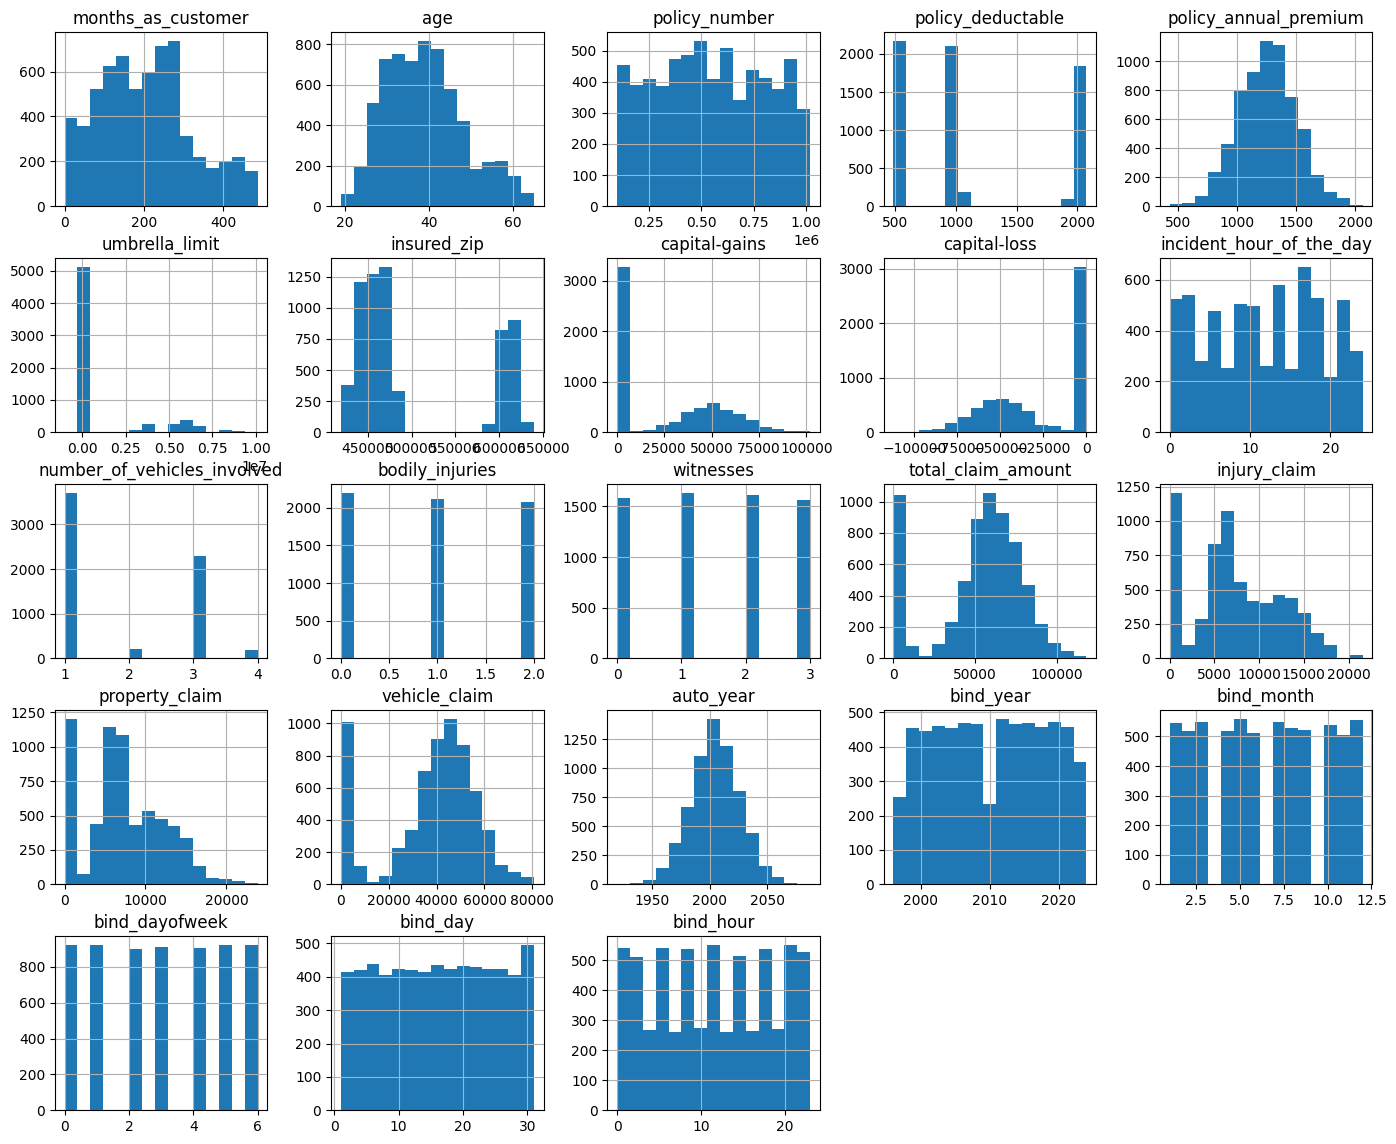

In [187]:
train_num.hist(bins=15, figsize=(17,14))
plt.show()

VIsualization of categorical variables

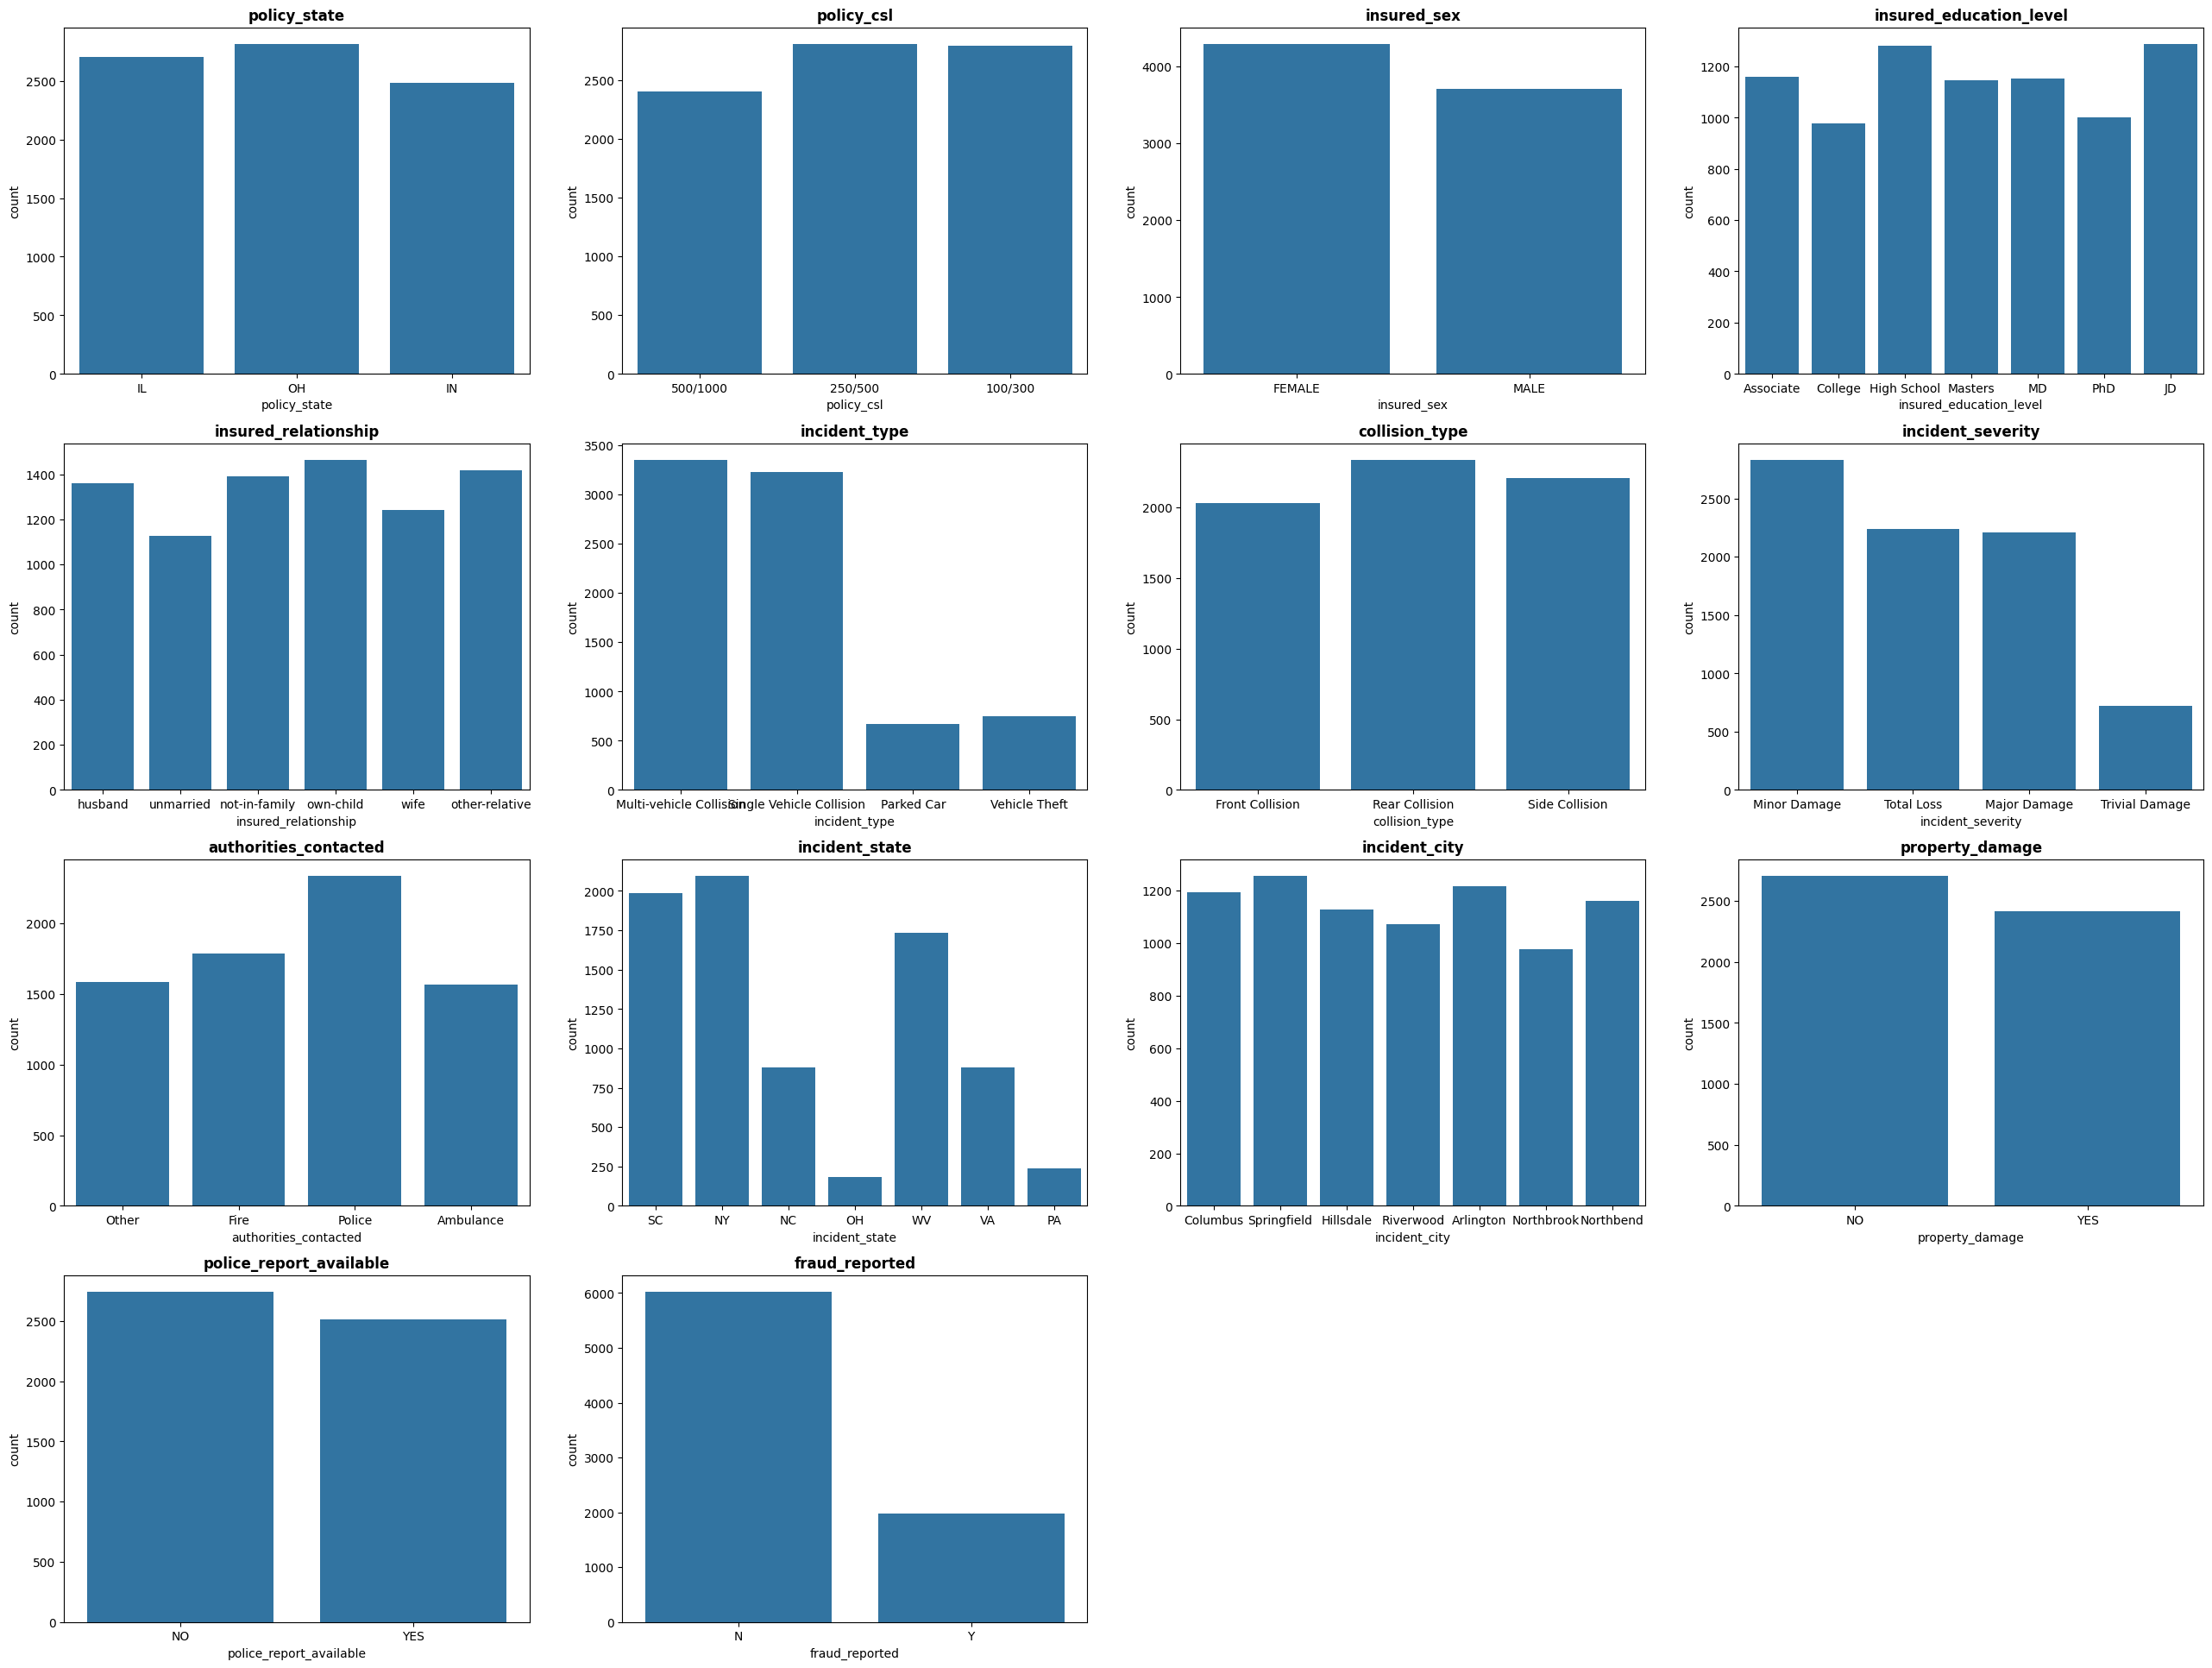

In [188]:
n_cols = 4
n_rows = (len(train_cat) + n_cols - 1) // n_cols

n_cols = 4
n_rows = (len(train_cat) + n_cols - 1) // n_cols

fig = plt.figure(figsize=(8*n_cols, 6*n_rows))

for i, col in enumerate(train_cat):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(col, fontsize=12, fontweight='bold')


Preprocessing

In [189]:
df_train = train.select_dtypes(include=['object']).columns.tolist()
df_train.remove('fraud_reported')

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train[df_train] = encoder.fit_transform(train[df_train])

label_encoder = LabelEncoder()
train['fraud_reported'] = label_encoder.fit_transform(train['fraud_reported'])

Feature Correlation

In [190]:
train_num = train._get_numeric_data()

corr = train_num.corr()['fraud_reported'].drop('fraud_reported')

In [191]:
corr.abs().sort_values(ascending=False)

incident_severity              0.409613
vehicle_claim                  0.170738
total_claim_amount             0.162872
property_claim                 0.134562
injury_claim                   0.088931
property_damage                0.061461
incident_state                 0.053040
umbrella_limit                 0.051970
number_of_vehicles_involved    0.051919
incident_type                  0.050370
insured_hobbies                0.046671
incident_city                  0.045480
witnesses                      0.043675
policy_csl                     0.043100
bodily_injuries                0.040925
authorities_contacted          0.038309
insured_sex                    0.030567
policy_number                  0.030274
collision_type                 0.029099
policy_state                   0.028982
insured_zip                    0.026631
make_model                     0.021361
months_as_customer             0.021299
policy_annual_premium          0.020640
police_report_available        0.016748


Heatmap Correlation

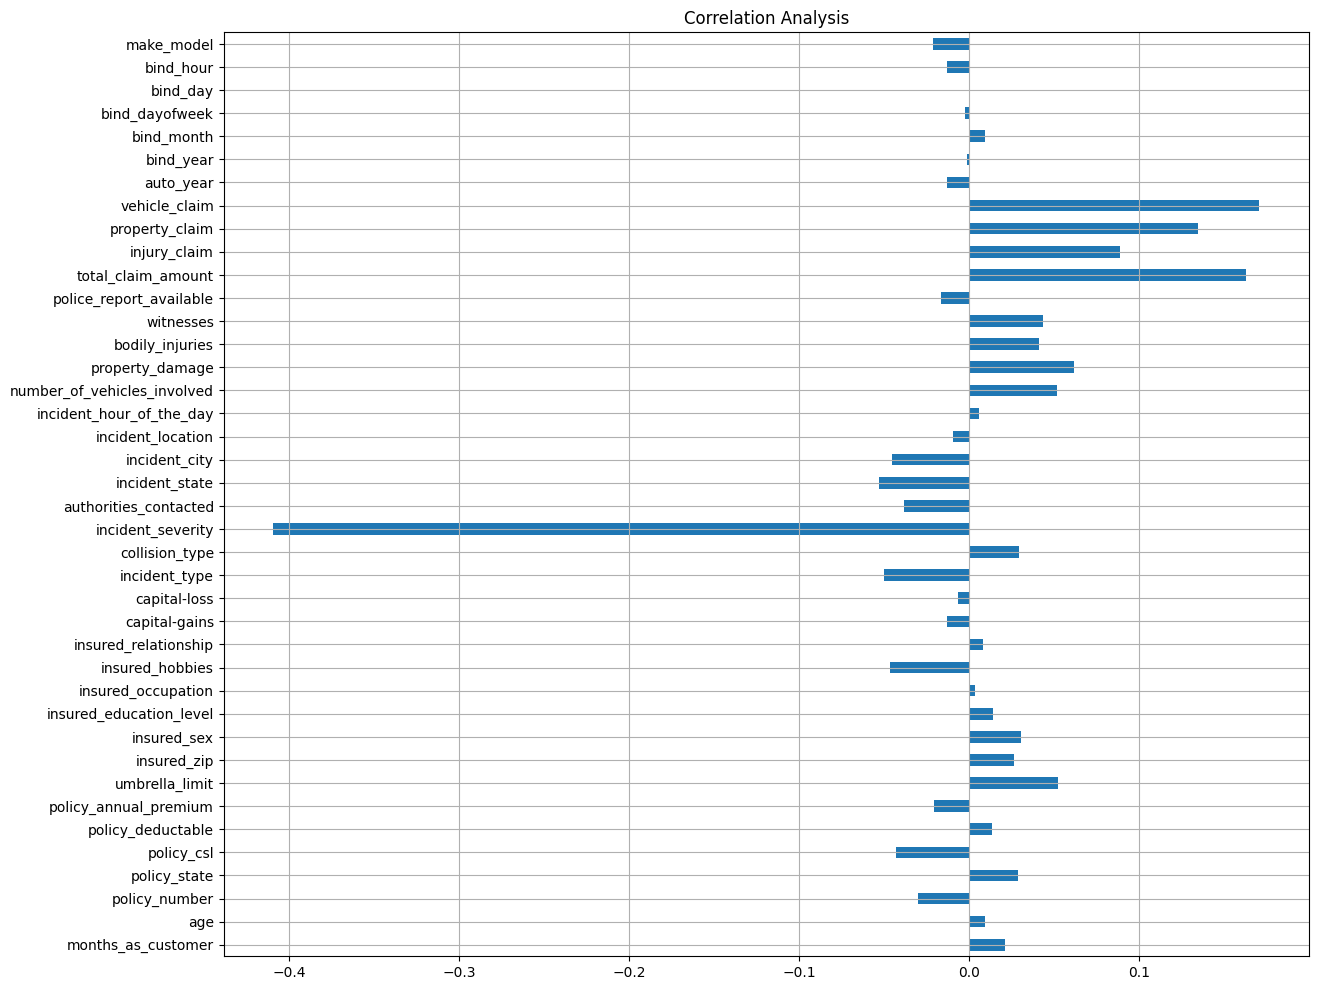

In [192]:
plt.figure(figsize=(14,12))
corr.plot(kind='barh', grid=True)
plt.title('Correlation Analysis')
plt.show()

Target Variable Distribution

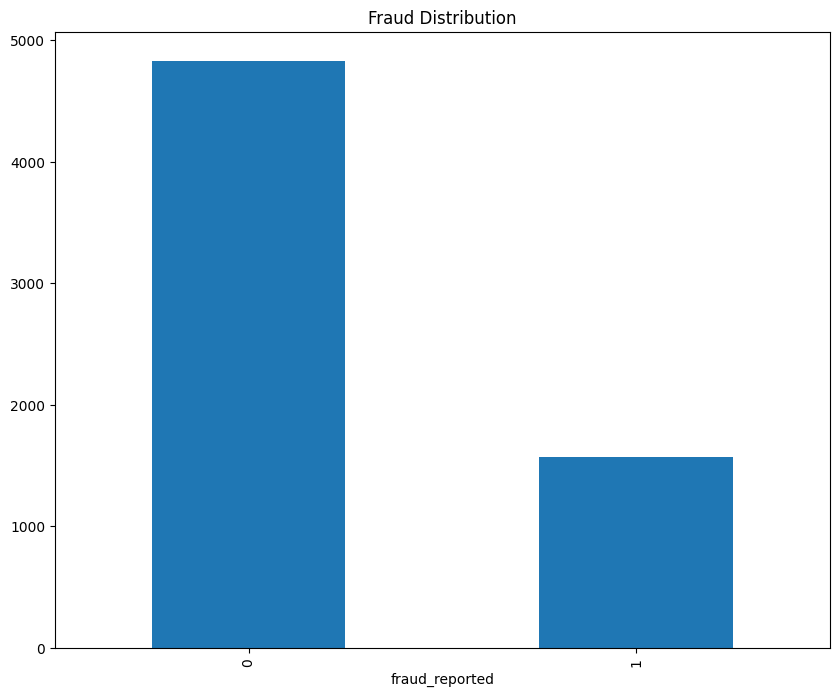

In [193]:
plt.figure(figsize=(10,8))
train['fraud_reported'].value_counts().plot(kind='bar')
plt.title('Fraud Distribution')
plt.show()

In [194]:
train.to_csv('insurance_fraud_train.csv', index=False)
train = pd.read_csv(r"C:\Users\pc\Documents\JUPYTER ML\ETEProject\src\notebook\insurance_fraud_train.csv")
train.head()

,months_as_customer,age,policy_number,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported,bind_year,bind_month,bind_dayofweek,bind_day,bind_hour,make_model
0,365,55,643651,2.0,0.0,1002,1094.148443,0,443289,0.0,3.0,7.0,0.0,4.0,43637,-71277,0.0,2.0,2.0,4.0,1.0,2.0,463.0,0,3,0.0,0,3,0.0,39096,0,0,39480,2040,0,2014,12,1,23,18,33.0
1,448,54,381162,0.0,1.0,501,1286.360395,0,596624,0.0,0.0,8.0,15.0,2.0,0,-55516,0.0,3.0,1.0,4.0,1.0,5.0,219.0,18,3,2.0,2,1,0.0,60096,6103,6137,49532,2006,0,2000,9,0,4,4,27.0
2,202,38,154023,0.0,1.0,504,1428.857533,0,594736,0.0,5.0,7.0,16.0,1.0,0,0,2.0,0.0,0.0,0.0,5.0,1.0,458.0,7,1,1.0,0,1,2.0,54930,0,6194,49803,2002,1,2002,8,4,2,9,25.0
3,297,49,742874,2.0,1.0,1005,1145.797021,0,444291,0.0,1.0,6.0,11.0,5.0,0,0,1.0,1.0,3.0,2.0,6.0,1.0,341.0,6,1,1.0,1,2,2.0,5343,901,912,3604,1983,0,2011,6,4,17,23,30.0
4,3,29,271139,0.0,0.0,504,1004.197706,5030810,611835,0.0,3.0,8.0,5.0,4.0,0,0,1.0,1.0,3.0,4.0,3.0,6.0,90.0,3,1,1.0,2,1,1.0,4888,497,1008,3483,1995,1,2017,2,2,15,0,23.0
